In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import shutil

In [4]:
path = "C:/Users/antoi/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"
combined_dir = os.path.join(path, "HAM10000_images_combined")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust based on your dataset stats
])

# Define mapping from var1 short codes to labels
label_mapping = {
    "akiec": 0,  # Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    "bcc": 1,    # Basal cell carcinoma
    "bkl": 2,    # Benign keratosis-like lesions
    "df": 3,     # Dermatofibroma
    "mel": 4,    # Melanoma
    "nv": 5,     # Melanocytic nevi
    "vasc": 6    # Vascular lesions
}


class SkinCancerDataset(Dataset):


    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the image path and label
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 1]+".jpg")
        image = Image.open(img_name).convert("RGB")

        # Convert the label to an integer
        label = int(label_mapping.get(self.annotations.iloc[idx, 2], -1))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
csv_file = os.path.join(path, "HAM10000_metadata.csv")
img_dir = os.path.join(path, "HAM10000_images_combined")

# Load the dataset with transformations
dataset = SkinCancerDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Split into training, validation, and testing sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = int(0.1 * len(dataset))    # 10% validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])



In [12]:
csv_file = os.path.join(path, "HAM10000_metadata.csv")
img_dir = os.path.join(path, "HAM10000_images_combined")
output_dir = os.path.join(path, "ImageFolder_Dataset")

metadata = pd.read_csv(csv_file)

# Create folders for train, val, and test sets with class subdirectories
for split in ['train', 'val', 'test']:
    for class_name in label_mapping.keys():
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Helper function to save images into the correct folders
def save_images(dataset, split_name):
    for idx in range(len(dataset)):
        img_name = metadata.iloc[dataset.indices[idx], 1] + ".jpg"
        img_path = os.path.join(img_dir, img_name)
        label = metadata.iloc[dataset.indices[idx], 2]
        class_name = label  # Use original class names for folders

        dest_folder = os.path.join(output_dir, split_name, class_name)
        dest_path = os.path.join(dest_folder, img_name)
        
        # Copy image to the destination
        shutil.copy(img_path, dest_path)


# Split into training, validation, and testing sets
train_size = int(0.8 * len(metadata))  # 80% training
val_size = int(0.1 * len(metadata))    # 10% validation
test_size = len(metadata) - train_size - val_size  # Remaining 10% for testing

# Split dataset indices
full_dataset = SkinCancerDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# Save images into train, val, and test directories
save_images(train_set, "train")
save_images(val_set, "val")
save_images(test_set, "test")

# Load the datasets using ImageFolder
train_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "train"), transform=transform)
val_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "val"), transform=transform)
test_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "test"), transform=transform)

In [13]:
image_datasets = {'train': train_imagefolder, 'val': val_imagefolder}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


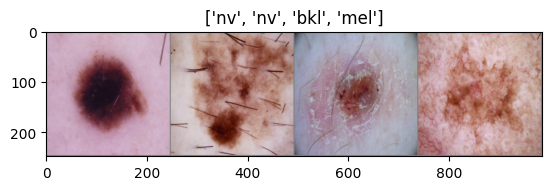

In [ ]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = 0.5 * inp + 0.5
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [23]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


c:\Users\antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# Parameters of newly constructed modules have requires_grad=True 
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


In [ ]:
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=4, shuffle=False, num_workers=0)

def test_model(model_conv, test_loader, criterion, device):
    model_conv.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # No need to track gradients during testing
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects.double() / total_samples

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

test_model(model_conv, test_loader, criterion, device)


Test Loss: 0.8926 Acc: 0.6916
